In [6]:
import math
import matplotlib.pyplot as plt
import numpy as np

states = [1, 2, 3]
Transition = {
    1: {1: 0, 2: 1/2, 3: 1/2},
    2: {1: 1/2, 2: 0, 3: 1/2},
    3: {1: 1/2, 2: 1/2, 3: 0},
}
obs = {1: 'a', 2: 'a', 3: 'c', 4: 'b', 5: 'b', 6: 'c'}
Observation = {
    1: {'a': 1/2, 'b': 0, 'c': 1/3},
    2: {'a': 1/2, 'b': 1/2, 'c': 1/3},
    3: {'a': 0, 'b': 1/2, 'c': 1/3},
}
Duration = {
    1: {1: 1, 2: 0, 3: 0},
    2: {1: 0, 2: 1, 3: 0},
    3: {1: 0, 2: 0, 3: 1},
}

{1: {1: 0.5, 2: 0.5, 3: 0.3333333333333333, 4: 0, 5: 0, 6: 0.3333333333333333}, 2: {1: 0.5, 2: 0.5, 3: 0.3333333333333333, 4: 0.5, 5: 0.5, 6: 0.3333333333333333}, 3: {1: 0, 2: 0, 3: 0.3333333333333333, 4: 0.5, 5: 0.5, 6: 0.3333333333333333}}


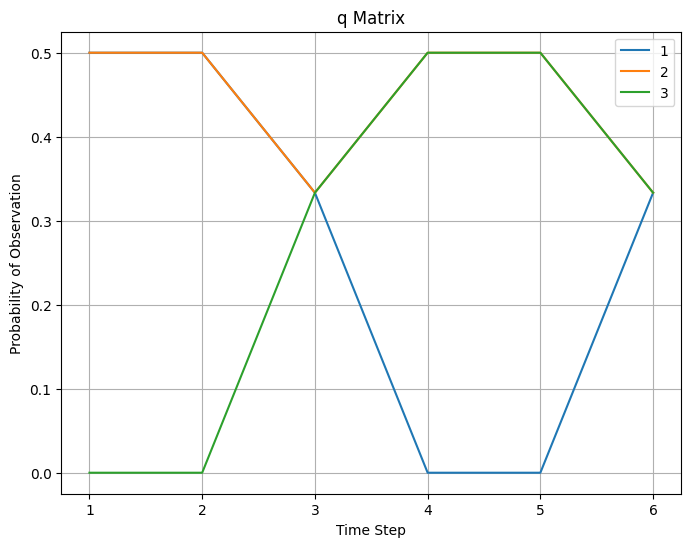

In [7]:
def q_matrix(obs, Observation):
    return {state: {i: Observation[state][obs[i]] for i in obs.keys()} for state in Observation}

q = q_matrix(obs, Observation)
print(q)

# plot
time_steps = range(1, len(obs)+1)
states = list(Observation.keys())

plt.figure(figsize=(8, 6))
for state in states:
    probs = [q[state][i] for i in range(1, len(obs)+1)]
    plt.plot(time_steps, probs, label=state)

plt.xlabel('Time Step')
plt.ylabel('Probability of Observation')
plt.title('q Matrix')
plt.legend()
plt.grid(True)
plt.show()

{1: {1: 0.3333333333333333, 2: 0.0, 3: 0.0}, 2: {1: 0.0, 2: 0.16666666666666666, 3: 0.0}, 3: {1: 0.027777777777777776, 2: 0.027777777777777776, 3: 0.0}, 4: {1: 0.0, 2: 0.0, 3: 0.0}, 5: {1: 0.0, 2: 0.003472222222222222, 3: 0.006944444444444444}, 6: {1: 0.001736111111111111, 2: 0.0, 3: 0.0023148148148148147}}


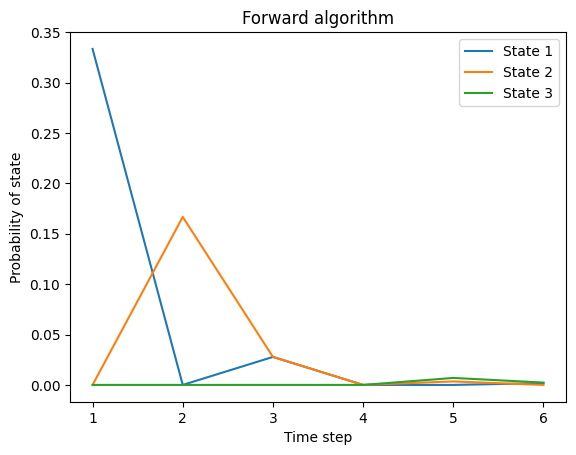

In [8]:
def forward(states, Transition, obs, q, Duration):
    T = len(obs)
    N = len(states)
    D = len(Duration[1])
    alpha = {timestep:{} for timestep in range(1, T+1)}
    start = {1: 1/3, 2: 1/3, 3: 1/3}

    # initialization
    # # alpha[1]
    # for i in states:
    #     alpha[1][i] = start[i] * Duration[i][1] * q[i][1]
    # # alpha[2]
    # for i in states:
    #     alpha[2][i] = start[i] * Duration[i][2] * math.prod(q[i][s] for s in range(1, 3))
    #     for j in states:
    #         if j != i:
    #             alpha[2][i] += alpha[1][j] * Transition[j][i] * Duration[i][1] * q[i][2]
    # # alpha[3]
    # for i in states:
    #     alpha[3][i] = start[i] * Duration[i][3] * math.prod(q[i][s] for s in range(1, 4))
    #     for d in range(1, 3):
    #         for j in states:
    #             if j != i:
    #                 alpha[3][i] += alpha[3-d][j] * Transition[j][i] * Duration[i][d] * math.prod(q[i][s] for s in range(4-d, 4))
    for t in range(1, D+1):
        for i in states:
            alpha[t][i] = start[i] * Duration[i][t] * math.prod(q[i][s] for s in range(1, t))
            for d in range(1, t):
                for j in states:
                    if j!=i:
                        alpha[t][i] += alpha[t-d][j] * Transition[j][i] * Duration[i][d] * math.prod(q[i][s] for s in range(t-d+1, t+1))
    # fill alpha[4:]
    for t in range(D+1, T+1):
        for j in states:
            alpha[t][j] = 0
            for i in states:
                for d in range(1, D+1):
                    alpha[t][j] += alpha[t-d][i] * Transition[i][j] * Duration[j][d] * math.prod(q[j][s] for s in range(t-d+1, t+1))
                
    return alpha

fwd = forward(states, Transition, obs, q, Duration)
print(fwd)

# plot each state
for state in states:
    plt.plot(range(1, len(obs)+1), [fwd[t][state] for t in range(1, len(obs)+1)], label=f"State {state}")

# label
plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Forward algorithm')
plt.legend()
plt.show()

{1: {1: 0.003472222222222222, 2: 0.001736111111111111, 3: 0.005208333333333333}, 2: {1: 0.006944444444444444, 2: 0.017361111111111112, 3: 0.010416666666666666}, 3: {1: 0.0625, 2: 0.041666666666666664, 3: 0.020833333333333332}, 4: {1: 0.08333333333333333, 2: 0.0, 3: 0.08333333333333333}, 5: {1: 0.0, 2: 0.16666666666666666, 3: 0.16666666666666666}, 6: {1: 1, 2: 1, 3: 1}}


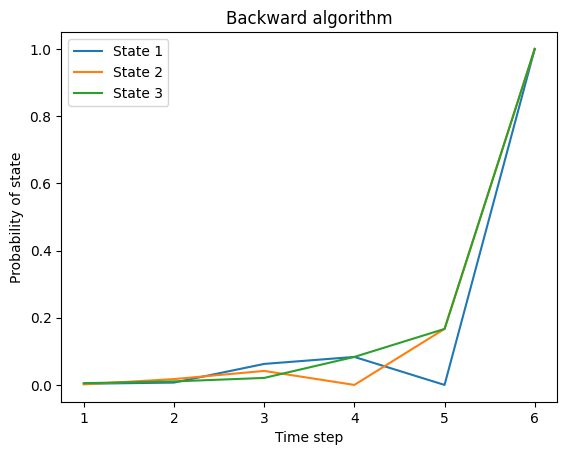

In [9]:
def backward(states, Transition, obs, q, Duration):
    T = len(obs)
    N = len(states)
    D = len(Duration[1])
    beta = {timestep: {} for timestep in range(1, T + 1)}

    # initialization, fill beta[-1]
    for i in states:
        beta[T][i] = 1

    # fill beta[:-1]
    for t in range(T - 1, 0, -1):
        for i in states:
            beta[t][i] = 0
            for j in states:
                for d in range(1, D + 1):
                    if t + d <= T:
                        beta[t][i] += beta[t + d][j] * Transition[i][j] * Duration[j][d] * math.prod(q[j][s] for s in range(t + 1, t + d + 1))

    return beta

bwd = backward(states, Transition, obs, q, Duration)
print(bwd)

# plot each state
for state in states:
    plt.plot(range(1, len(obs)+1), [bwd[t][state] for t in range(1, len(obs)+1)], label=f"State {state}")

# label
plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Backward algorithm')
plt.legend()
plt.show()

[{1: 0.2857142857142857, 2: 0.0, 3: 0.0}, {1: 0.0, 2: 0.7142857142857143, 3: 0.0}, {1: 0.42857142857142855, 2: 0.2857142857142857, 3: 0.0}, {1: 0.0, 2: 0.0, 3: 0.0}, {1: 0.0, 2: 0.14285714285714285, 3: 0.2857142857142857}, {1: 0.42857142857142855, 2: 0.0, 3: 0.5714285714285714}]


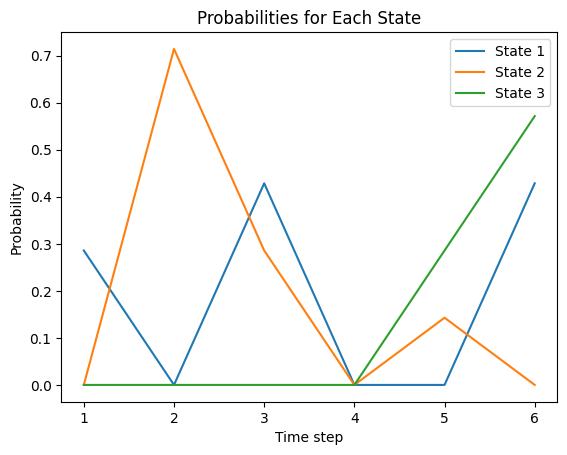

In [10]:
def fb_alg(states, Transition, obs, q, Duration):
    T = len(obs)
    alpha = forward(states, Transition, obs, q, Duration)
    beta = backward(states, Transition, obs, q, Duration)
    fb_probs = []
    for t in range(1, len(alpha)+1):
        fb_probs.append({i: alpha[t][i] * beta[t][i] for i in states})
    # normalize
    fb_sum = sum(alpha[T][i] for i in states)
    for t in range(len(alpha)):
        for s in states:
            fb_probs[t][s] /= fb_sum if fb_sum != 0 else 1
    return fb_probs

fb_probs = fb_alg(states, Transition, obs, q, Duration)
print(fb_probs)

# plot each state
for state in states:
    probs = [fb_probs[t][state] for t in range(len(fb_probs))]
    plt.plot(range(1, len(fb_probs) + 1), probs, label=f'State {state}')

# label
plt.xlabel('Time step')
plt.ylabel('Probability')
plt.title('Probabilities for Each State')
plt.legend()
plt.show()